In [1]:
from prompt_to_prompt.ptp_utils import init_latent, diffusion_step, register_attention_control, latent2image
from prompt_to_prompt.attention import AttentionStore
from prompt_to_prompt.visualise import view_images
from prompt_to_prompt.null_text_inversion import NullTextInversion

/vol/biomedic3/rrr2417/cxr-generation/notebooks/diffedit_diffusers/lib/python3.9/site-packages/transformers/utils/hub.py:123: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
from tqdm import tqdm

generator = torch.Generator().manual_seed(8888)
torch_dtype = torch.float32
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
LOW_RESOURCE = False

In [4]:
from torchvision.datasets import OxfordIIITPet
ds = OxfordIIITPet(root=".", split="trainval", download=True)

In [5]:
model_path = "runwayml/stable-diffusion-v1-5"
model = StableDiffusionPipeline.from_pretrained(
    model_path,
    torch_dtype=torch_dtype,
    safety_checker=None,
).to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [13]:
def run_and_display(diffuser, prompts, controller, ddim_latents=None, run_baseline=False, generator=None, uncond_embeddings=None, verbose=True):
    if run_baseline:
        print("w.o. prompt-to-prompt")
        images, latent = run_and_display(prompts, EmptyControl(), ddim_latents=ddim_latents, run_baseline=False, generator=generator)
        print("with prompt-to-prompt")
    images, x_t = text2image_ldm_stable(diffuser, prompts, controller, ddim_latents=ddim_latents, num_inference_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator, uncond_embeddings=uncond_embeddings)
    if verbose:
        view_images(images)
    return images, x_t

In [8]:
@torch.no_grad()
def text2image_ldm_stable(
    model,
    prompt,
    controller,
    num_inference_steps,
    guidance_scale,
    generator = None,
    ddim_latents = None,
    uncond_embeddings = None,
    start_time = 50,
    return_type = 'image',
    mask_image = None,
):
    batch_size = len(prompt)
    register_attention_control(model, controller)
    height = width = 512
    
    text_input = model.tokenizer(
        prompt,
        padding="max_length",
        max_length=model.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    text_embeddings = model.text_encoder(text_input.input_ids.to(model.device))[0]
    max_length = text_input.input_ids.shape[-1]
    if uncond_embeddings is None:
        uncond_input = model.tokenizer(
            [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
        )
        uncond_embeddings_ = model.text_encoder(uncond_input.input_ids.to(model.device))[0]
    else:
        uncond_embeddings_ = None

    latent, latents = init_latent(ddim_latents[-1], model, height, width, generator, batch_size)
    model.scheduler.set_timesteps(num_inference_steps)
    for i, t in enumerate(tqdm(model.scheduler.timesteps[-start_time:])):
        if uncond_embeddings_ is None:
            context = torch.cat([uncond_embeddings[i].expand(*text_embeddings.shape), text_embeddings])
        else:
            context = torch.cat([uncond_embeddings_, text_embeddings])
        latents = diffusion_step(model, controller, latents, context, t, guidance_scale, low_resource=False)
        if mask_image is not None:
            latents = mask_image * latents + (1 - mask_image) * ddim_latents[-i]
        
    if return_type == 'image':
        image = latent2image(model.vae, latents)
    else:
        image = latents
    return image, latent

In [ ]:
@torch.no_grad()
def generate_mask(model, source_prompt, target_prompt, )

In [9]:
nti = NullTextInversion(model, NUM_DIFFUSION_STEPS, GUIDANCE_SCALE)

## Null-text Inversion

In [11]:
import numpy as np

image_path = np.array(ds[0][0])
prompt = "A picture of an abyssinian"
(image_gt, image_enc), ddim_latents, uncond_embeddings = nti.invert(image_path, prompt, offsets=(0, 0, 200, 0), verbose=True)

print("Modify or remove offsets according to your image!")

DDIM inversion...
Null-text optimization...


100%|███████████████████████████| 500/500 [01:11<00:00,  6.99it/s]

Modify or remove offsets according to your image!


100%|█████████████████████████████| 50/50 [00:03<00:00, 16.27it/s]


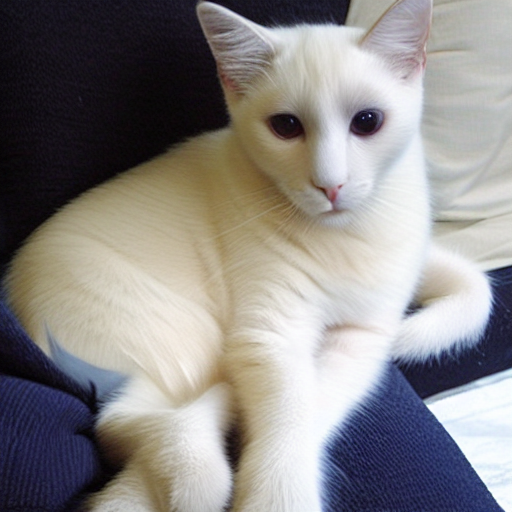

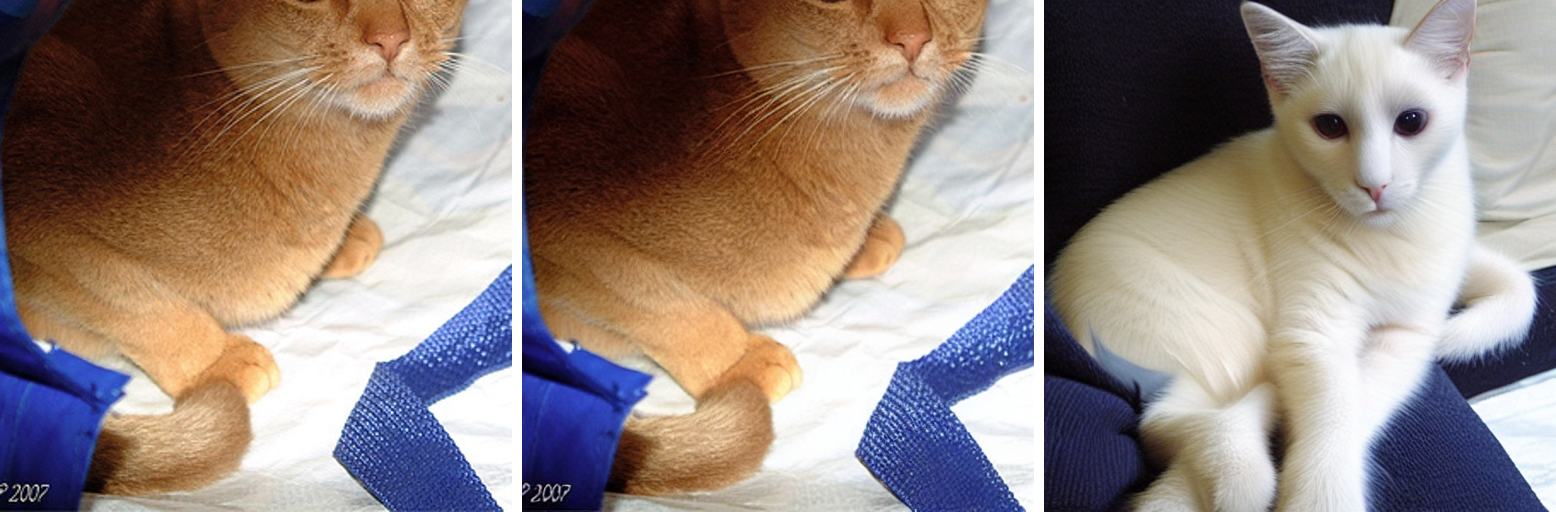

In [14]:
prompts = ["A picture of a siamese"]
controller = AttentionStore(low_resource=LOW_RESOURCE)
image_inv, x_t = run_and_display(model, prompts, controller, ddim_latents=ddim_latents, uncond_embeddings=uncond_embeddings, run_baseline=False, generator=generator)
view_images([image_gt, image_enc, image_inv[0]])